In [8]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset


import numpy as np
import pandas as pd

from PIL import Image

from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [9]:
model = models.resnet18(pretrained=True)

classifier = nn.Sequential(
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(512, 1000)
)

model.fc = classifier

c:\Users\janko\OneDrive\Pulpit\Artificial intelligence\Magisterka\topography-public\venv_torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\janko\OneDrive\Pulpit\Artificial intelligence\Magisterka\topography-public\venv_torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# load the model from state_dict
model.load_state_dict(torch.load('../models/best_steel_fourier_model.pth'))
model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [15]:
class ImageDataset(Dataset):
    def __init__(self, path: str, parameters: pd.DataFrame, transform=None) -> None:
        self.image_paths = np.array([path + filename for filename in parameters['filename'].to_numpy()])
        self.labels = parameters['epsilon'].to_numpy()
        self.transform = transform

    def __getitem__(self, inx):
        image_path = self.image_paths[inx]
        label_float_epsilon = self.labels[inx]
        target = np.zeros(shape=(1000,))
        target[int(label_float_epsilon*1000)] = 1
        image = Image.open(image_path)
        image = np.array(image)
        # repeat grayscale value three times for all RGB channels
        image = np.repeat(image[..., np.newaxis], 3, -1)
        if self.transform:
            image = self.transform(image)
        return image, torch.from_numpy(target)

    def __len__(self):
        return len(self.image_paths)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def prepare_image_for_prediction(image_path: str) -> torch.Tensor:
    df = pd.DataFrame({"filename": [image_path.split('/')[-1]], "epsilon": [0]})
    dataset = ImageDataset(path=image_path.rsplit('/', 1)[0] + '/', parameters=df, transform=transform)
    image_tensor, _ = dataset[0]
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.cuda()
    return image_tensor

def prediction_to_real_value(prediction: torch.Tensor) -> float:
    """
    Convert the model's prediction tensor to a real value in the range [0.0, 1.0].
    
    Parameters:
    - prediction (torch.Tensor): The prediction tensor, typically of shape (batch_size, 1000).
    
    Returns:
    - float: The real value in the range [0.0, 1.0].
    """
    max_index = torch.argmax(prediction, dim=1).item()
    real_value = max_index / 1000.0
    return real_value

In [16]:
sample_image = prepare_image_for_prediction("../data/generated/fourier/steel/fourier_steel_00000.png")
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(sample_image, target=torch.argmax(model(sample_image), 1),n_steps=30)

In [17]:
from matplotlib.colors import LinearSegmentedColormap
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)


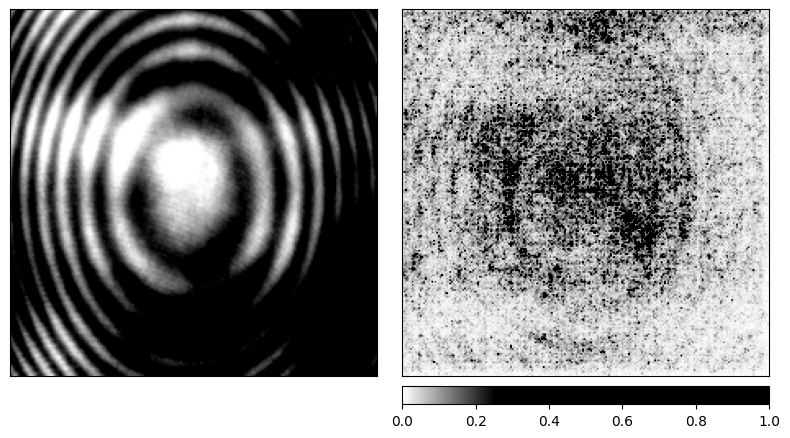

In [18]:
noise_tunnel = NoiseTunnel(integrated_gradients)
image_np = sample_image.squeeze().cpu().numpy().transpose(1,2,0)
attributions_ig_nt = noise_tunnel.attribute(sample_image, nt_samples=10, nt_type='smoothgrad_sq', target=torch.argmax(model(sample_image), 1))
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      image_np,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

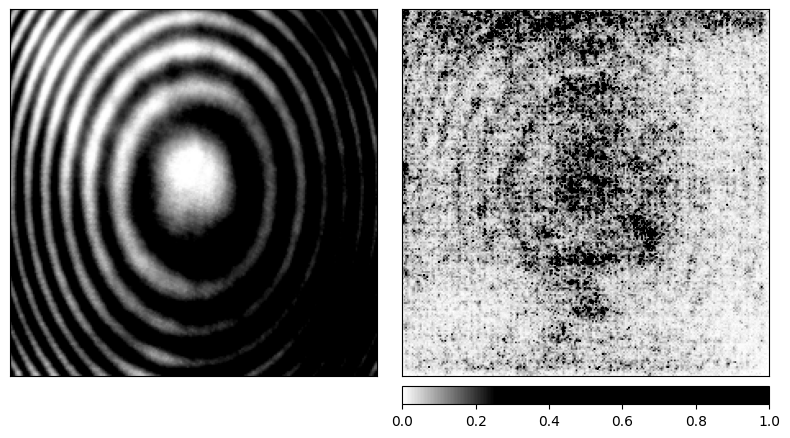

In [19]:
sample_image = prepare_image_for_prediction("../data/generated/fourier/steel/fourier_steel_00408.png")
attributions_ig = integrated_gradients.attribute(sample_image, target=torch.argmax(model(sample_image), 1),n_steps=30)
image_np = sample_image.squeeze().cpu().numpy().transpose(1,2,0)
attributions_ig_nt = noise_tunnel.attribute(sample_image, nt_samples=10, nt_type='smoothgrad_sq', target=torch.argmax(model(sample_image), 1))
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      image_np,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

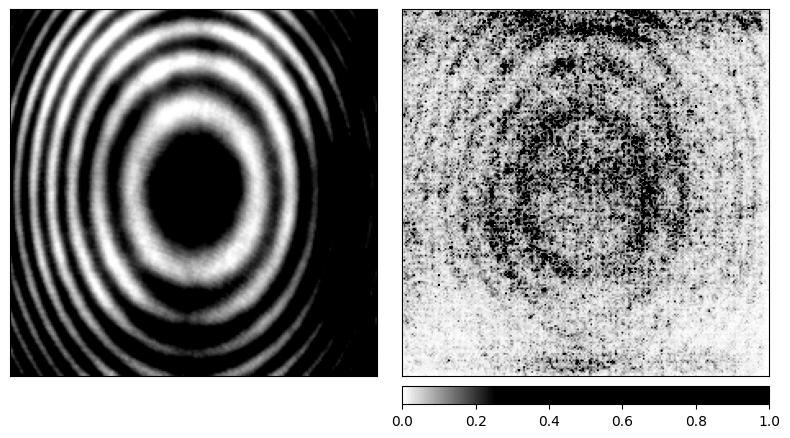

In [20]:
sample_image = prepare_image_for_prediction("../data/generated/fourier/steel/fourier_steel_06919.png")
attributions_ig = integrated_gradients.attribute(sample_image, target=torch.argmax(model(sample_image), 1),n_steps=30)
image_np = sample_image.squeeze().cpu().numpy().transpose(1,2,0)
attributions_ig_nt = noise_tunnel.attribute(sample_image, nt_samples=10, nt_type='smoothgrad_sq', target=torch.argmax(model(sample_image), 1))
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      image_np,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

## Original images ##

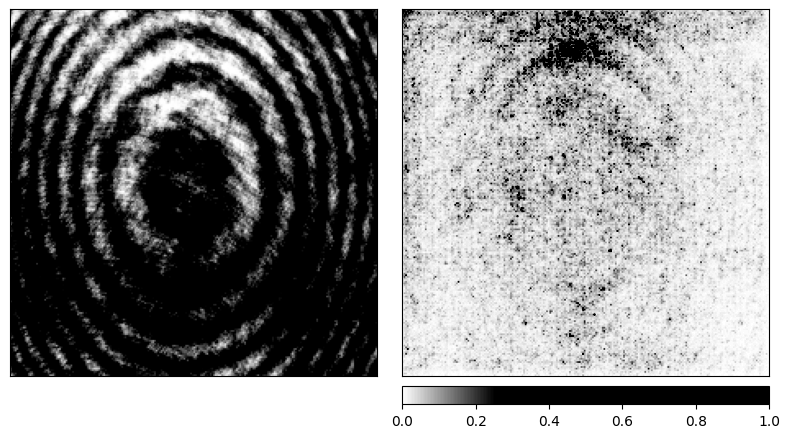

In [21]:
sample_image = prepare_image_for_prediction("../data/raw/steel/1channel/00000.png")
attributions_ig = integrated_gradients.attribute(sample_image, target=torch.argmax(model(sample_image), 1),n_steps=30)
image_np = sample_image.squeeze().cpu().numpy().transpose(1,2,0)
attributions_ig_nt = noise_tunnel.attribute(sample_image, nt_samples=10, nt_type='smoothgrad_sq', target=torch.argmax(model(sample_image), 1))
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      image_np,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

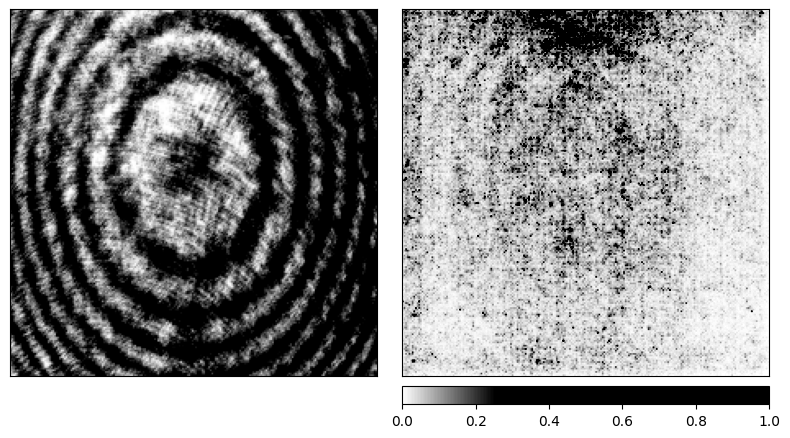

In [22]:
sample_image = prepare_image_for_prediction("../data/raw/steel/1channel/15000.png")
attributions_ig = integrated_gradients.attribute(sample_image, target=torch.argmax(model(sample_image), 1),n_steps=30)
image_np = sample_image.squeeze().cpu().numpy().transpose(1,2,0)
attributions_ig_nt = noise_tunnel.attribute(sample_image, nt_samples=10, nt_type='smoothgrad_sq', target=torch.argmax(model(sample_image), 1))
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      image_np,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

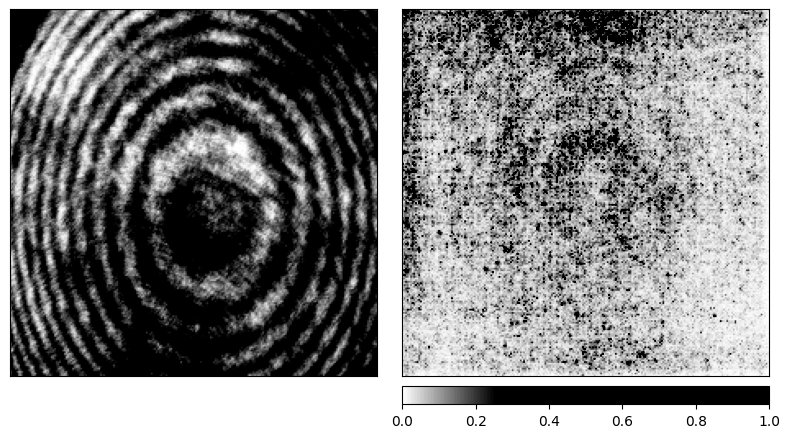

In [23]:
sample_image = prepare_image_for_prediction("../data/raw/steel/1channel/25000.png")
attributions_ig = integrated_gradients.attribute(sample_image, target=torch.argmax(model(sample_image), 1),n_steps=30)
image_np = sample_image.squeeze().cpu().numpy().transpose(1,2,0)
attributions_ig_nt = noise_tunnel.attribute(sample_image, nt_samples=10, nt_type='smoothgrad_sq', target=torch.argmax(model(sample_image), 1))
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      image_np,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)
